# Walmart : Triptype Classification

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Objective : 
> ### 각 고객의 구매정보에 따른 구매 건의 Type을 분류

### (2) Data : 
### train : 647054 rows, 7 columns
| Index 	| Feature               	| Description                                  	|
|-------	|-----------------------	|----------------------------------------------	|
| 1     	| TripType              	| Target                                       	|
| 2     	| VisitNumber           	| 각 손님의 Index                              	|
| 3     	| Weekday               	| VisitNumber가 발생한 요일                    	|
| 4     	| Upc                   	| 구매한 제품의 고유한 바코드                  	|
| 5     	| ScanCount             	| 구매 수량 ( 반품 시 `-` 값으로 표기 )        	|
| 6     	| DepartmentDescription 	| 제품의 대분류                                	|
| 7     	| FinelineNumber        	| 월마트 자체적으로 정의 한 제품의 소분류 코드 	|

(3) _UPC code description_
- Check Digit : 숫자가 정확하게 구성되어 있는가를 보장해주는 컴퓨터 검증 숫자. UPC의 신뢰도를 검증

<img src="data/upc.png">



<br>

### test : 653646 rows, 6 columns
- TripType을 제외한 동일한 컬럼


<br>

### (3) Evaluation : 
> ### Multi-class log loss
> $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

# [ Result ]: 
> #### - 참가 팀 : 총 1047 팀 
> #### - 최종 점수 : 0.795
> #### - 캐글 등수 : 295등 (상위 28%)


# [ Approach ]:
> #### - 주어진 컬럼을 통한 Feature Engineering
    - Parsing Information (UPC, ScanCount)
    - Feature Encoding
    - Dummy Variables
    - Column Statistic
    
> #### - XGBoost

* * * *

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from walmart_utils import *

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# [ EDA ]

In [4]:
train.head()

TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   
3        26            8  Friday  2.238404e+09          2   
4        26            8  Friday  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0

## Train Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [13]:
# How many unique values does each column have
print("< Number of unique values per column >")
print(train.T.apply(lambda x: x.nunique(), axis=1))

< Number of unique values per column >
TripType                    38
VisitNumber              95674
Weekday                      7
Upc                      97714
ScanCount                   39
DepartmentDescription       68
FinelineNumber            5195
dtype: int64


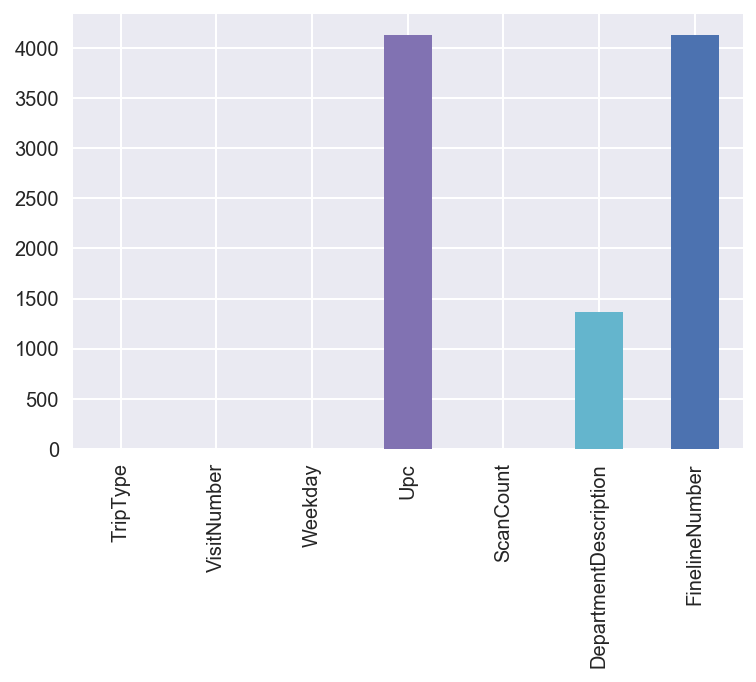

In [6]:
train.isnull().sum().plot(kind='bar')

In [7]:
np.sort(train.TripType.unique())

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

In [8]:
train_triptypes = train.drop_duplicates("VisitNumber")

In [15]:
a = train_triptypes["TripType"]
a = a.value_counts()

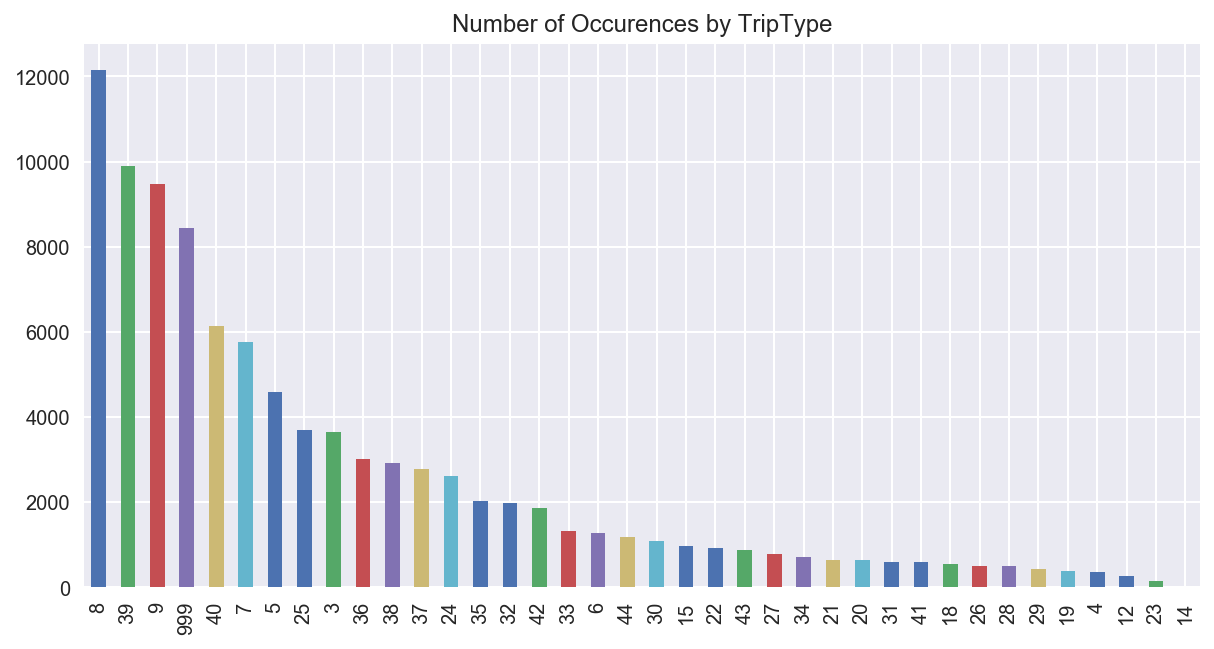

In [16]:
graph = a.plot(kind='bar', figsize=(10, 5))
graph.set_title("Number of Occurences by TripType")
plt.show()

- ### TripType의 출현이 균등하게 분배되지 않음.

##### Most frequent TripType

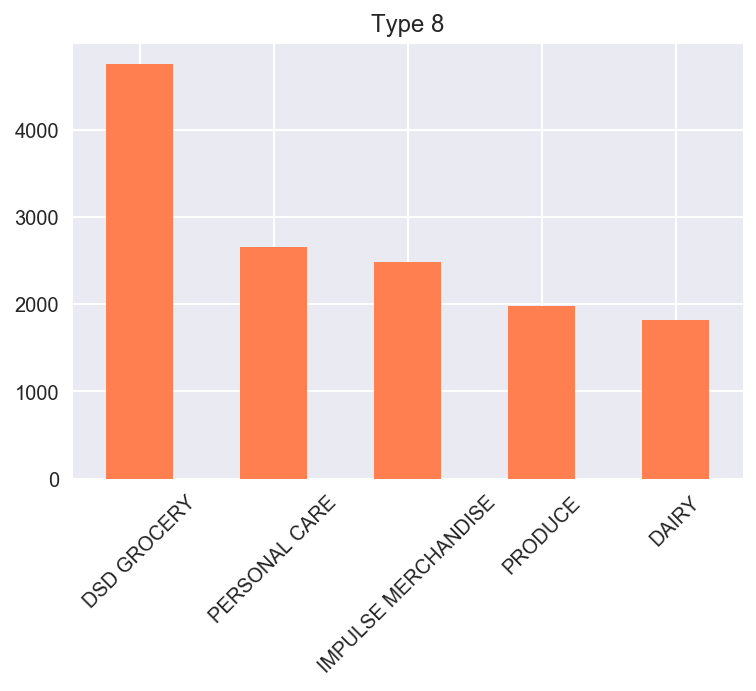

In [30]:
type_8 = train[train.TripType == 8]
type_8_items = type_8[["TripType","DepartmentDescription"]]
type_8_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 8", color="coral")
plt.xticks(fontsize=10)
plt.show()

##### Most infrequent TripType

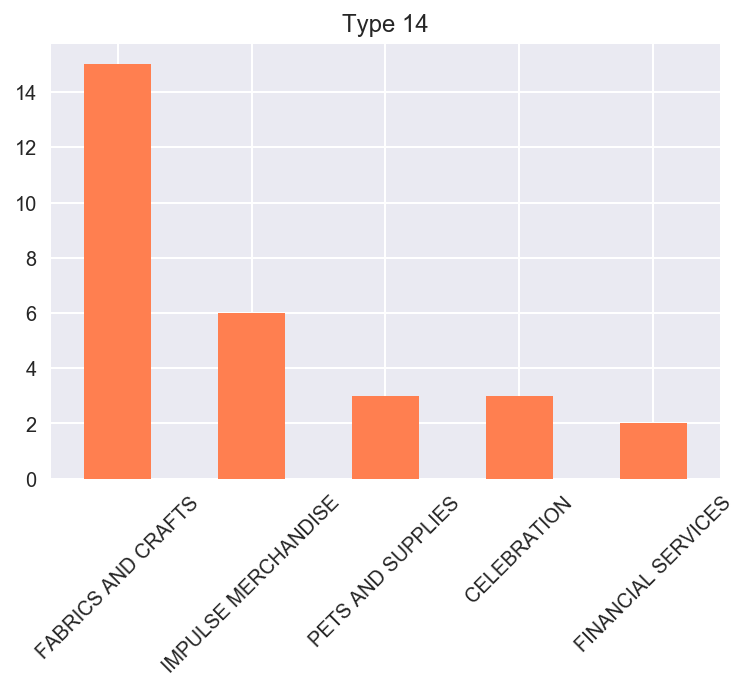

In [31]:
type_14 = train[train.TripType == 14]
type_14_items = type_14[["TripType","DepartmentDescription"]]
type_14_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 14", color="coral")
plt.xticks(fontsize=10)
plt.show()

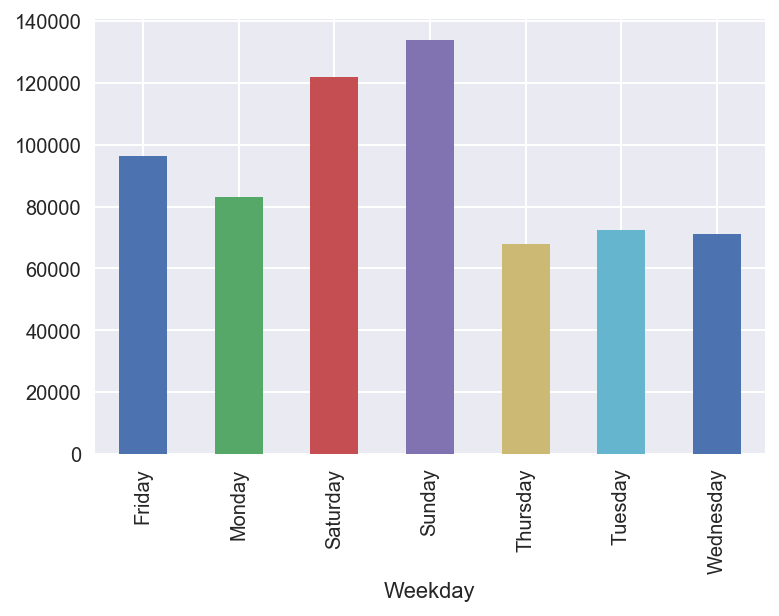

In [20]:
# Plot total number of Weekday
train.groupby(['Weekday']).size().plot('bar')
plt.show()

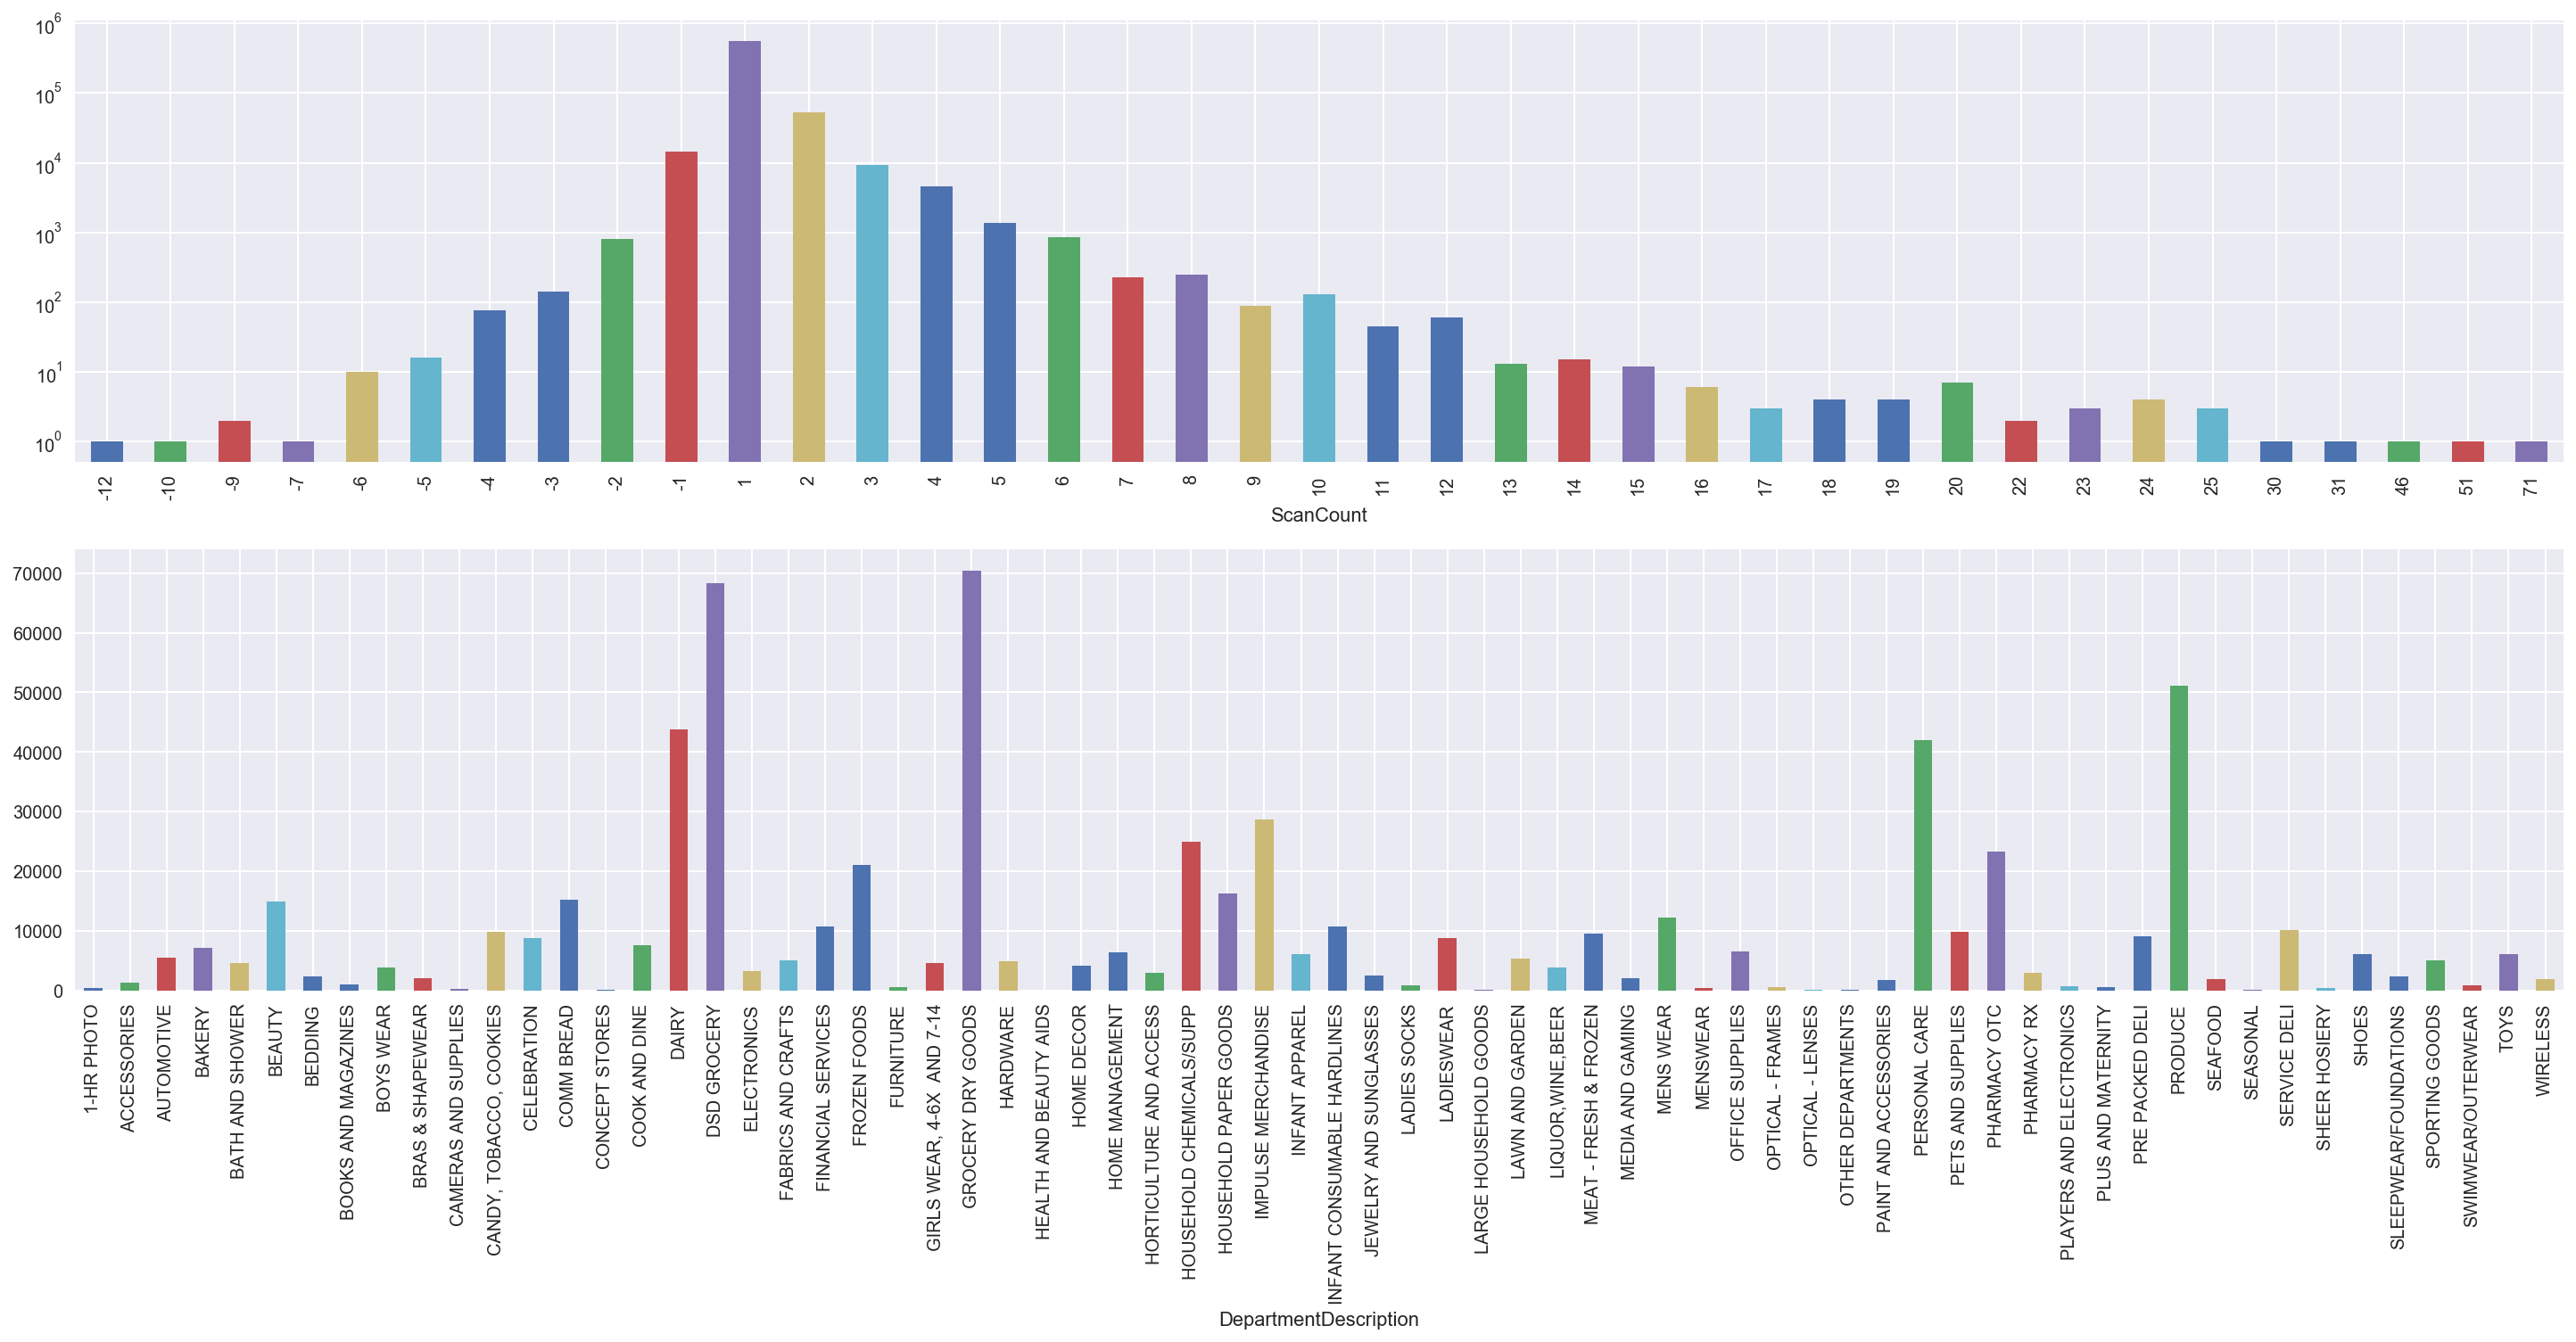

In [23]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25, 10))

# Plot total number of ScanCounts    ## 이거 왜 이러죠 ㅠㅜㅠㅜㅠㅜㅠㅜㅠㅜㅜㅠㅜㅠㅜㅠㅜㅠㅜㅠㅜㅠㅜ
ax2 = fig.add_subplot(211)
train.groupby(['ScanCount'], as_index=False).size().plot('bar', logy=True)

# Plot total number of DepartmentDescriptions
ax3 = fig.add_subplot(212)
train.groupby(['DepartmentDescription'], as_index=False).size().plot('bar')

plt.show()

In [69]:
pd.crosstab(index=train['DepartmentDescription'], columns=train['TripType']).idxmax()

TripType
3               FINANCIAL SERVICES
4                     PHARMACY OTC
5                     PHARMACY OTC
6                 LIQUOR,WINE,BEER
7                     SERVICE DELI
8                      DSD GROCERY
9                        MENS WEAR
12                     DSD GROCERY
14              FABRICS AND CRAFTS
15                     CELEBRATION
18                            TOYS
19                     ELECTRONICS
20                      AUTOMOTIVE
21              FABRICS AND CRAFTS
22                     ELECTRONICS
23         PLAYERS AND ELECTRONICS
24                   COOK AND DINE
25                       MENS WEAR
26                        HARDWARE
27                 LAWN AND GARDEN
28                  SPORTING GOODS
29                            TOYS
30                           SHOES
31                        WIRELESS
32     INFANT CONSUMABLE HARDLINES
33        HOUSEHOLD CHEMICALS/SUPP
34               PETS AND SUPPLIES
35                     DSD GROCERY
36         

In [15]:
triptype = list(train['TripType'].unique())
triptype.sort()

fig = plt.figure(figsize=(30, 300))
fig.canvas.set_window_title('DepartmentDescription Frequency per TripType')

for idx, i in enumerate(triptype):
    
    
    ax = plt.subplot(19, 2, idx+1)
    triptype_each = train[train['TripType'].isin([i])]
    sns.countplot(y='DepartmentDescription', data=triptype_each)
    ax.set_title("TripType " + str(i))
    
plt.show()

# [ Preprocessing ]

### UPC company code 분리

In [16]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

In [17]:
train.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0       999            5  Friday  68113152929         -1   
1        30            7  Friday  60538815980          1   
2        30            7  Friday   7410811099          1   
3        26            8  Friday   2238403510          2   
4        26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber company  
0     FINANCIAL SERVICES          1000.0  681131  
1                  SHOES          8931.0  605388  
2          PERSONAL CARE          4504.0  741081  
3  PAINT AND ACCESSORIES          3565.0  223840  
4  PAINT AND ACCESSORIES          1017.0  200661

### Return 발생 여부 표기

In [18]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [19]:
train.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0       999            5  Friday  68113152929         -1   
1        30            7  Friday  60538815980          1   
2        30            7  Friday   7410811099          1   
3        26            8  Friday   2238403510          2   
4        26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber company  Return  
0     FINANCIAL SERVICES          1000.0  681131     1.0  
1                  SHOES          8931.0  605388     0.0  
2          PERSONAL CARE          4504.0  741081     0.0  
3  PAINT AND ACCESSORIES          3565.0  223840     0.0  
4  PAINT AND ACCESSORIES          1017.0  200661     0.0

### Weekday 인코딩

In [20]:
wd = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
      "Friday": 4, "Saturday": 5, "Sunday": 6}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

In [21]:
train.head()

TripType  VisitNumber  Weekday          Upc  ScanCount  \
0       999            5        4  68113152929         -1   
1        30            7        4  60538815980          1   
2        30            7        4   7410811099          1   
3        26            8        4   2238403510          2   
4        26            8        4   2006613744          2   

   DepartmentDescription  FinelineNumber company  Return  
0     FINANCIAL SERVICES          1000.0  681131     1.0  
1                  SHOES          8931.0  605388     0.0  
2          PERSONAL CARE          4504.0  741081     0.0  
3  PAINT AND ACCESSORIES          3565.0  223840     0.0  
4  PAINT AND ACCESSORIES          1017.0  200661     0.0

### 실제 판매 수량

In [22]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [23]:
train.head()

TripType  VisitNumber  Weekday          Upc  ScanCount  \
0       999            5        4  68113152929         -1   
1        30            7        4  60538815980          1   
2        30            7        4   7410811099          1   
3        26            8        4   2238403510          2   
4        26            8        4   2006613744          2   

   DepartmentDescription  FinelineNumber company  Return  Pos_Sum  
0     FINANCIAL SERVICES          1000.0  681131     1.0        0  
1                  SHOES          8931.0  605388     0.0        1  
2          PERSONAL CARE          4504.0  741081     0.0        1  
3  PAINT AND ACCESSORIES          3565.0  223840     0.0        2  
4  PAINT AND ACCESSORIES          1017.0  200661     0.0        2

### 반품 수량

In [24]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [25]:
train.head()

TripType  VisitNumber  Weekday          Upc  ScanCount  \
0       999            5        4  68113152929         -1   
1        30            7        4  60538815980          1   
2        30            7        4   7410811099          1   
3        26            8        4   2238403510          2   
4        26            8        4   2006613744          2   

   DepartmentDescription  FinelineNumber company  Return  Pos_Sum  Neg_Sum  
0     FINANCIAL SERVICES          1000.0  681131     1.0        0       -1  
1                  SHOES          8931.0  605388     0.0        1        0  
2          PERSONAL CARE          4504.0  741081     0.0        1        0  
3  PAINT AND ACCESSORIES          3565.0  223840     0.0        2        0  
4  PAINT AND ACCESSORIES          1017.0  200661     0.0        2        0

### UPC Check Digit 추가

In [26]:
train["check"] = train.Upc.apply(check_digit)
test["check"] = test.Upc.apply(check_digit)

In [27]:
train.head()

TripType  VisitNumber  Weekday          Upc  ScanCount  \
0       999            5        4  68113152929         -1   
1        30            7        4  60538815980          1   
2        30            7        4   7410811099          1   
3        26            8        4   2238403510          2   
4        26            8        4   2006613744          2   

   DepartmentDescription  FinelineNumber company  Return  Pos_Sum  Neg_Sum  \
0     FINANCIAL SERVICES          1000.0  681131     1.0        0       -1   
1                  SHOES          8931.0  605388     0.0        1        0   
2          PERSONAL CARE          4504.0  741081     0.0        1        0   
3  PAINT AND ACCESSORIES          3565.0  223840     0.0        2        0   
4  PAINT AND ACCESSORIES          1017.0  200661     0.0        2        0   

   check  
0      7  
1      9  
2      2  
3      2  
4      1

# [ Feature Engineering ]

### VisitNumber 별 가장 빈도가 잦은 FinelineNumber

In [28]:
# new feature

train_fineline = train[["VisitNumber", "FinelineNumber"]]
test_fineline = test[["VisitNumber", "FinelineNumber"]]

train_fineline = train_fineline.groupby("VisitNumber", as_index=False).agg(mode)
train_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

test_fineline = test_fineline.groupby("VisitNumber", as_index=False).agg(mode)
test_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

In [29]:
train_fineline.head()

VisitNumber  MF_FinelineNumber
0            5             1000.0
1            7             8931.0
2            8             3565.0
3            9              115.0
4           10             2008.0

### VisitNumber 별 

In [30]:
train_upc_fine = train[["VisitNumber", "Upc", "FinelineNumber"]]
test_upc_fine = test[["VisitNumber", "Upc", "FinelineNumber"]]

train_upc_fine_group = train_upc_fine.groupby("VisitNumber", as_index=False).count()
train_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                     "FinelineNumber": "N_FinelineNumber"}, inplace=True)
test_upc_fine_group = test_upc_fine.groupby("VisitNumber", as_index=False).count()
test_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                    "FinelineNumber": "N_FinelineNumber"}, inplace=True)

In [31]:
train_upc_fine_group.head()

VisitNumber  N_Upc  N_FinelineNumber
0            5      1                 1
1            7      2                 2
2            8     23                22
3            9      3                 3
4           10      3                 3

In [32]:
train = train.drop(["Upc", "FinelineNumber"], axis=1)
test = test.drop(["Upc", "FinelineNumber"], axis=1)

### DepartmentDescription의 더미변수 생성

In [33]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()

In [34]:
train_dd.head()

VisitNumber  1-HR PHOTO  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  \
0            5           0            0           0       0                0   
1            7           0            0           0       0                0   
2            8           0            0           0       0                0   
3            9           0            0           0       0                0   
4           10           0            0           0       0                0   

   BEAUTY  BEDDING  BOOKS AND MAGAZINES  BOYS WEAR    ...     SEAFOOD  \
0       0        0                    0          0    ...           0   
1       0        0                    0          0    ...           0   
2       0        0                    0          0    ...           0   
3       0        0                    0          0    ...           0   
4       0        0                    0          0    ...           0   

   SEASONAL  SERVICE DELI  SHEER HOSIERY  SHOES  SLEEPWEAR/FOUNDATIONS  \
0         0             0              0      0                      0   
1         0             0              0      1                      0   
2         0             0              0      0                      0   
3         0             0              0      0                      0   
4         0             0              0      0                      0   

   SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  
0               0                   0     0         0  
1               0                   0     0         0  
2               0                   0     0         0  
3               0                   0     0         0  
4               0                   0     0         0  

[5 rows x 69 columns]

### 각 VisitNumber별 가장 많이 구매한 제품의 기업 코드

In [35]:
train_company = train[["VisitNumber", "company"]]
test_company = test[["VisitNumber", "company"]]

train_company = train_company.groupby("VisitNumber", as_index=False).agg(mode)
test_company = test_company.groupby("VisitNumber", as_index=False).agg(mode)

In [36]:
train_company.head()

VisitNumber company
0            5  681131
1            7  605388
2            8  223840
3            9  107008
4           10  641441

### 각 VisitNumber 별 가장 많이 구매한 제품의 Check Digit

In [37]:
train_check = train[["VisitNumber", "check"]]
test_check = test[["VisitNumber", "check"]]

train_check = train_check.groupby("VisitNumber", as_index=False).agg(mode)
test_check = test_check.groupby("VisitNumber", as_index=False).agg(mode)

In [38]:
train_check.head()

VisitNumber  check
0            5      7
1            7      9
2            8      5
3            9      4
4           10      8

### VisitNumber를 index로 하는 groupby & merge

In [39]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train_by_max = train[["TripType", "VisitNumber", "Weekday", "Return"]]
test_by_max = test[["VisitNumber", "Weekday", "Return"]]

train_by_max = train_by_max.groupby("VisitNumber", as_index=False).max()
test_by_max = test_by_max.groupby("VisitNumber", as_index=False).max()

In [40]:
train = train_by_sum.merge(train_by_max, on=["VisitNumber"])
train = train.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_company, on=["VisitNumber"])
train = train.merge(train_check, on=["VisitNumber"])
train = train.merge(train_fineline, on=["VisitNumber"])
train = train.merge(train_upc_fine_group, on=["VisitNumber"])

test = test_by_sum.merge(test_by_max, on=["VisitNumber"])
test = test.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_company, on=["VisitNumber"])
test = test.merge(test_check, on=["VisitNumber"])
test = test.merge(test_fineline, on=["VisitNumber"])
test = test.merge(test_upc_fine_group, on=["VisitNumber"])

In [41]:
train.head()

VisitNumber  ScanCount  Pos_Sum  Neg_Sum  TripType  Weekday  Return  \
0            5         -1        0       -1       999        4     1.0   
1            7          2        2        0        30        4     0.0   
2            8         28       30       -2        26        4     1.0   
3            9          3        3        0         8        4     0.0   
4           10          3        3        0         8        4     0.0   

   1-HR PHOTO  ACCESSORIES  AUTOMOTIVE        ...         \
0           0            0           0        ...          
1           0            0           0        ...          
2           0            0           0        ...          
3           0            0           0        ...          
4           0            0           0        ...          

   SLEEPWEAR/FOUNDATIONS  SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  \
0                      0               0                   0     0         0   
1                      0               0                   0     0         0   
2                      0               0                   0     0         0   
3                      0               0                   0     0         0   
4                      0               0                   0     0         0   

   company  check  MF_FinelineNumber  N_Upc  N_FinelineNumber  
0   681131      7             1000.0      1                 1  
1   605388      9             8931.0      2                 2  
2   223840      5             3565.0     23                22  
3   107008      4              115.0      3                 3  
4   641441      8             2008.0      3                 3  

[5 rows x 80 columns]

- ### test data에서는 발생하지 않는 DepartmentDescription 제거
- ### train & target 분리

In [42]:
y = train["TripType"]
train = train.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)

### 각 VisitNumber 별 판매된 아이템의 DepartmentDescription 빈도

In [43]:
from walmart_utils import category_counts

In [44]:
%%time
train = category_counts(train)
test = category_counts(test)

CPU times: user 25.3 s, sys: 185 ms, total: 25.5 s
Wall time: 26 s


In [45]:
train.head()

VisitNumber  ScanCount  Pos_Sum  Neg_Sum  Weekday  Return  CategoryCounts  \
0            5         -1        0       -1        4     1.0               1   
1            7          2        2        0        4     0.0               2   
2            8         28       30       -2        4     1.0               6   
3            9          3        3        0        4     0.0               2   
4           10          3        3        0        4     0.0               2   

   1-HR PHOTO  ACCESSORIES  AUTOMOTIVE        ...         \
0           0            0           0        ...          
1           0            0           0        ...          
2           0            0           0        ...          
3           0            0           0        ...          
4           0            0           0        ...          

   SLEEPWEAR/FOUNDATIONS  SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  \
0                      0               0                   0     0         0   
1                      0               0                   0     0         0   
2                      0               0                   0     0         0   
3                      0               0                   0     0         0   
4                      0               0                   0     0         0   

   company  check  MF_FinelineNumber  N_Upc  N_FinelineNumber  
0   681131      7             1000.0      1                 1  
1   605388      9             8931.0      2                 2  
2   223840      5             3565.0     23                22  
3   107008      4              115.0      3                 3  
4   641441      8             2008.0      3                 3  

[5 rows x 79 columns]

### VisitNumber 별로 발생한 FinelineNumber와 UPC의 비율

In [46]:
train["Upc_Depts"] = train["N_Upc"] / train["N_FinelineNumber"]
test["Upc_Depts"] = test["N_Upc"] / test["N_FinelineNumber"]

In [47]:
train.head()

VisitNumber  ScanCount  Pos_Sum  Neg_Sum  Weekday  Return  CategoryCounts  \
0            5         -1        0       -1        4     1.0               1   
1            7          2        2        0        4     0.0               2   
2            8         28       30       -2        4     1.0               6   
3            9          3        3        0        4     0.0               2   
4           10          3        3        0        4     0.0               2   

   1-HR PHOTO  ACCESSORIES  AUTOMOTIVE    ...      SPORTING GOODS  \
0           0            0           0    ...                   0   
1           0            0           0    ...                   0   
2           0            0           0    ...                   0   
3           0            0           0    ...                   0   
4           0            0           0    ...                   0   

   SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  company  check  MF_FinelineNumber  \
0                   0     0         0   681131      7             1000.0   
1                   0     0         0   605388      9             8931.0   
2                   0     0         0   223840      5             3565.0   
3                   0     0         0   107008      4              115.0   
4                   0     0         0   641441      8             2008.0   

   N_Upc  N_FinelineNumber  Upc_Depts  
0      1                 1   1.000000  
1      2                 2   1.000000  
2     23                22   1.045455  
3      3                 3   1.000000  
4      3                 3   1.000000  

[5 rows x 80 columns]

### Weeday, Return의 더미변수 생성

In [48]:
train = pd.get_dummies(train, columns=["Weekday", "Return"])
test = pd.get_dummies(test, columns=["Weekday", "Return"])

In [49]:
train.head()

VisitNumber  ScanCount  Pos_Sum  Neg_Sum  CategoryCounts  1-HR PHOTO  \
0            5         -1        0       -1               1           0   
1            7          2        2        0               2           0   
2            8         28       30       -2               6           0   
3            9          3        3        0               2           0   
4           10          3        3        0               2           0   

   ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER     ...      Upc_Depts  \
0            0           0       0                0     ...       1.000000   
1            0           0       0                0     ...       1.000000   
2            0           0       0                0     ...       1.045455   
3            0           0       0                0     ...       1.000000   
4            0           0       0                0     ...       1.000000   

   Weekday_0  Weekday_1  Weekday_2  Weekday_3  Weekday_4  Weekday_5  \
0          0          0          0          0          1          0   
1          0          0          0          0          1          0   
2          0          0          0          0          1          0   
3          0          0          0          0          1          0   
4          0          0          0          0          1          0   

   Weekday_6  Return_0.0  Return_1.0  
0          0           0           1  
1          0           1           0  
2          0           0           1  
3          0           1           0  
4          0           1           0  

[5 rows x 87 columns]

# [ Model Generation ]

- XGBoost

- # GridSearch ?????

In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [51]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y_labeled, random_state=0)

In [53]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [54]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.25}

evals = [(dtrain, 'train'), (dtest, 'eval')]


bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
               early_stopping_rounds=10,)

[0]	train-mlogloss:2.93537	eval-mlogloss:2.9471
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.34326	eval-mlogloss:2.37095
[2]	train-mlogloss:1.91318	eval-mlogloss:1.95558
[3]	train-mlogloss:1.65661	eval-mlogloss:1.71024
[4]	train-mlogloss:1.48188	eval-mlogloss:1.54478
[5]	train-mlogloss:1.34987	eval-mlogloss:1.42094
[6]	train-mlogloss:1.24623	eval-mlogloss:1.32529
[7]	train-mlogloss:1.16356	eval-mlogloss:1.24927
[8]	train-mlogloss:1.09548	eval-mlogloss:1.18797
[9]	train-mlogloss:1.03786	eval-mlogloss:1.13655
[10]	train-mlogloss:0.9907	eval-mlogloss:1.09534
[11]	train-mlogloss:0.949775	eval-mlogloss:1.06015
[12]	train-mlogloss:0.915182	eval-mlogloss:1.03132
[13]	train-mlogloss:0.883135	eval-mlogloss:1.00522
[14]	train-mlogloss:0.855546	eval-mlogloss:0.983329
[15]	train-mlogloss:0.830766	eval-mlogloss:0.963848
[16]	train-mlogloss:0.809331	eval-mlogloss:0.947327
[1

##### logarithmic loss

In [55]:
from sklearn.metrics import log_loss
my_test = xgb.DMatrix(X_test.values)
test_predictions = bst.predict(my_test)
print("logarithmic loss :", log_loss(y_test, test_predictions).round(5))

logarithmic loss : 0.78525


##### Accuracy score

In [58]:
yprob = test_predictions.reshape(y_test.shape[0], 38)
ylabel = np.argmax(yprob, axis=1)
accuracy = 100 *(1 - (sum(int(ylabel[i]) != y_test[i]
                         for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 73.74%


In [ ]:
classes = np.array(list(set(label_enc.inverse_transform(y_labeled))))

In [ ]:
dmtest = xgb.DMatrix(test.values) 
pred_proba = bst.predict(dmtest)

proba_df = pd.DataFrame(pred_proba, columns=classes)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([test[["VisitNumber"]], proba_df], axis=1)
sub_df.to_csv("data/team_SWYA_submission.csv", index=False)